In [44]:
%matplotlib inline 
#%load_ext autoreload 
%reload_ext autoreload
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import
import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting
import sys
sys.path.append('/Users/RAJ/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
from PIL import Image
import glob, os


In [45]:
x_images = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/stsdas/bin.macosx/x_isophote.e'

IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [46]:
from pyraf import iraf

iraf.tables()   
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')

iraf.unlearn('bmodel')

In [47]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
def save_to_fits(image, name):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(name, overwrite=True)
    
    return

def show_illustris(img_cen, img_sat, img_icl, img_all):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
    
    return fig


In [49]:

n = int(raw_input("How many galaxies do you want to model: "))

illustris_file = 'galaxies_orig_11.2.hdf5'

f = h5py.File(illustris_file, 'r')
map_stars_insitu = np.array(f['map_stars_insitu'])
map_stars_exsitu = np.array(f['map_stars_exsitu'])
map_size = f.attrs['stellar_map_size']
n_pixels = f.attrs['stellar_map_np']
#pixel_scale = 2 * (map_size / n_pixels)

def insitu_list():
    
    fits_list = []
    nonfits_list = []
    fits_prefix = []
    #loc = '/Users/raj/work'
    loc = '.'
    
    for i, insitu in enumerate(map_stars_insitu[:n, 0, 1]):
                
        nonfits_list.append(insitu)
        
        prefix = 'illustris_xy_%s' % str(i+1).strip()
        
        fits_output = prefix + '_insitu.fits'
        
        fits_prefix.append(prefix)
        fits_list.append(fits_output)
        
        save_to_fits(insitu, fits_output)
    
    return nonfits_list, fits_list, fits_prefix

hdf5_list_ins, images_list_ins, fits_prefixlist_ins = insitu_list()

How many galaxies do you want to model: 6


In [50]:


def exsitu_list():
    fits_list = []
    nonfits_list = []
    fits_prefix = []
    loc = '.'
    
    for i, exsitu in enumerate(map_stars_exsitu[:n,0,1]):
        nonfits_list.append(exsitu)
        prefix = 'illustris_xy_%s' % str(i+1).strip()
        fits_output = prefix + '_exsitu.fits'
        fits_prefix.append(prefix)
        fits_list.append(fits_output)
        save_to_fits(exsitu,fits_output)
    return nonfits_list, fits_list, fits_prefix

hdf5_list_exs, images_list_exs, fits_prefixlist_exs = exsitu_list()
    

In [51]:
os.path.splitext(images_list_ins[0])[0]


'illustris_xy_1_insitu'

In [58]:
def onedmodel(data, data1, pixel_scale=5.0): 
    
    prefix = os.path.splitext(data1)[0]
    
    if prefix.find("insitu") == -1:
        r = 'navy'
        g = 'exsitu'
    else:
        r = 'forestgreen'
        g = 'insitu' 
    
    bkg_cen = sep.Background(data, 
                         bw=10, bh=10, 
                         fw=5, fh=5)
    objs_cen, seg_cen = sep.extract(data - bkg_cen.back(), 
                                20.0,
                                err=bkg_cen.globalrms,
                                minarea=1000,
                                deblend_nthresh=24, 
                                deblend_cont=0.1,
                                segmentation_map=True)
    
   
    
    iso_cen_2, iso_cen_2_bin = galSBP.galSBP(data1, 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=220, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=pixel_scale, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)
    try:
        os.remove(prefix + '_cen_ellip_2.fits')
    except Exception:
        pass
    
    iraf.bmodel(parent=data1, 
            table=iso_cen_2_bin,
            output=prefix + '_cen_ellip_2.fits',
            minsma=0.0,
            highar='no')
    
    iso_cen_3, iso_cen_3_bin = galSBP.galSBP(data1, 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=iso_cen_2['avg_q'][0], 
                                         galPA=iso_cen_2['avg_pa'][0], 
                                         maxSma=250, 
                                         iniSma=50.0, 
                                         stage=3, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=pixel_scale, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False, 
                                         verbose=True)
    try:
        os.remove(prefix + '_cen_ellip_3.fits')
    except Exception:
        pass
    
    iraf.bmodel(parent=data1, 
            table=iso_cen_3_bin,
            output=prefix + '_cen_ellip_3.fits',
            minsma=0.0,
            highar='no')
    
    fig = plt.figure(figsize=(8, 7))
    ax1 = plt.subplot(1, 1, 1)
    ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
    dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / pixel_scale**2), 
                      r_eff=8, n=4.0)
    ax1.plot((iso_cen_3['sma'] * pixel_scale) ** 0.25, 
         np.log10(iso_cen_3['intens'] / pixel_scale**2),label=g, linewidth=3.0,c=r)

    ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
    ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax1.set_xlim(1.0, 4.5)
    ax1.set_ylim(4.0, 10.0)
    ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
    plt.legend(loc=0)
    fig.savefig('./plots/'+ prefix +'.png')


----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_xy_1_insitu.fits
###      Input Image   : temp_JYKBS.fits
###      Output Binary : illustris_xy_1_insitu_ellip_2.bin
----------------------------------------------------------------------------------------------------
---------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  27333.86
###     Current outer background :  27333.86
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

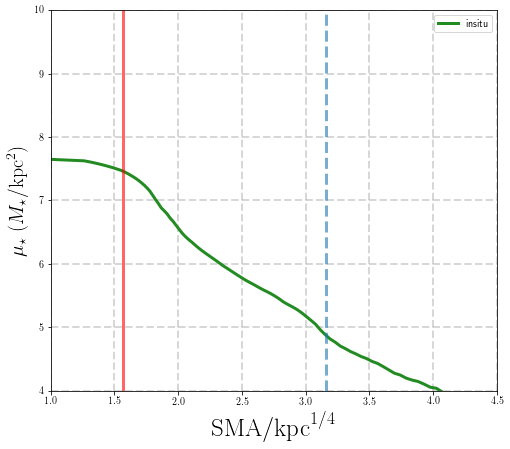

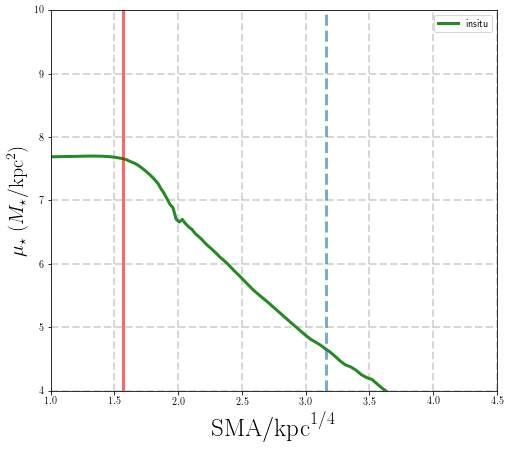

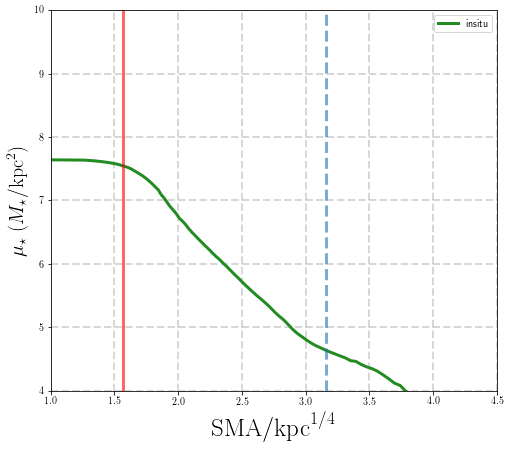

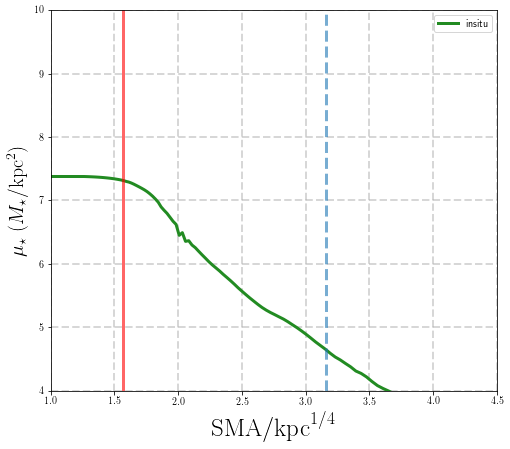

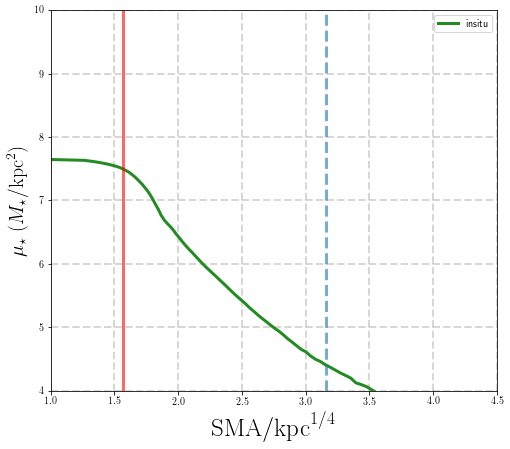

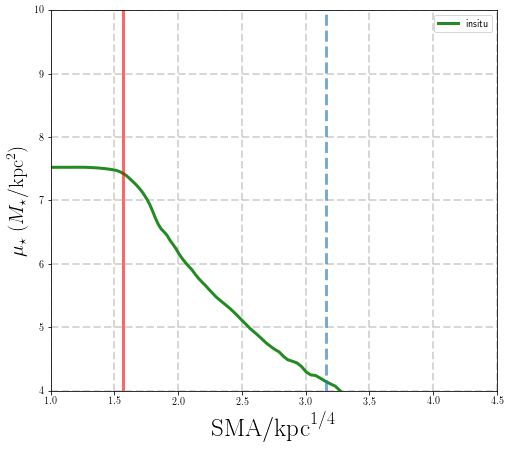

In [59]:
_1_D_plot = map(onedmodel, hdf5_list_ins, images_list_ins)

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_xy_1_exsitu.fits
###      Input Image   : temp_12TJS.fits
###      Output Binary : illustris_xy_1_exsitu_ellip_2.bin
----------------------------------------------------------------------------------------------------
---------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  320420.2
###     Current outer background :  320420.2
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------

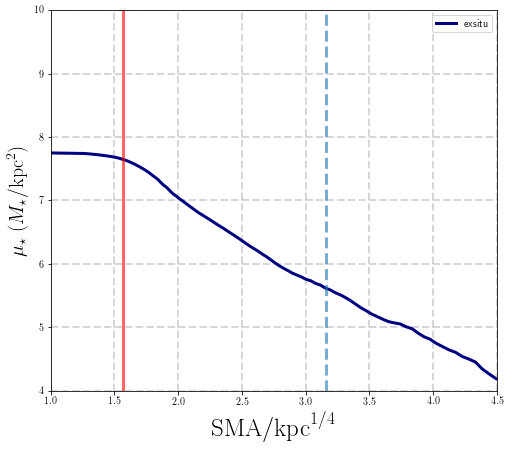

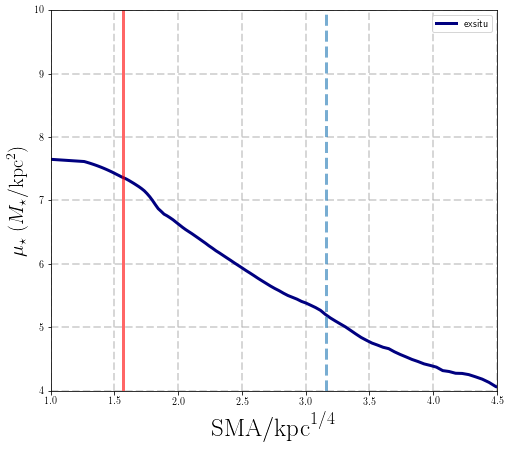

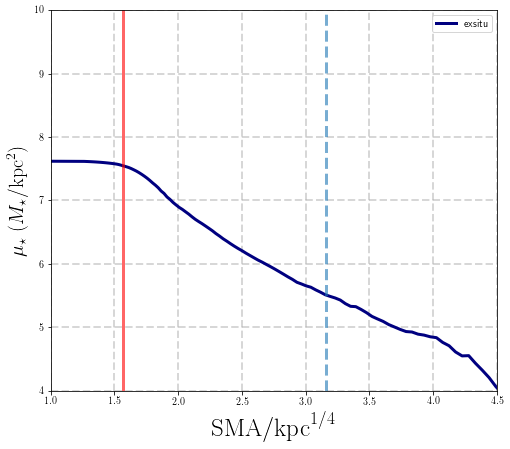

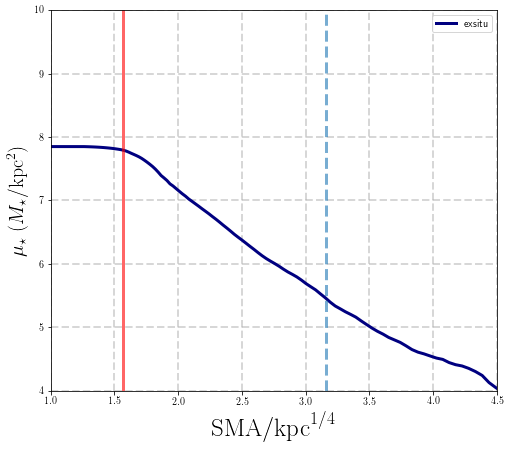

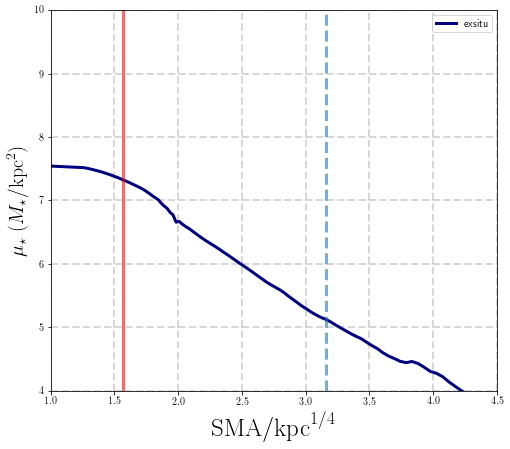

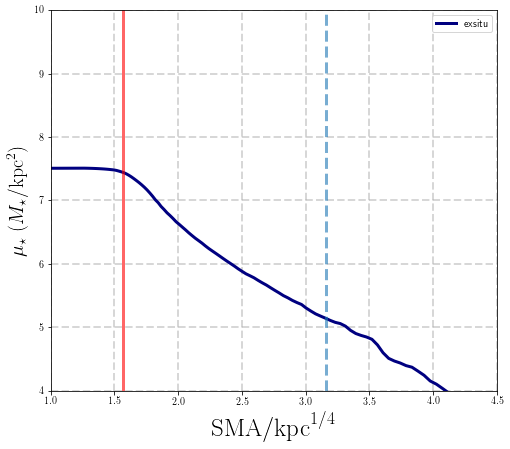

In [60]:
_1_D_plot = map(onedmodel, hdf5_list_exs, images_list_exs)

In [61]:
def insitu_exsitu():
    i = 1
    while i <= n:
        background = Image.open("./plots/illustris_xy_"+str(i)+"_insitu.png")
        foreground = Image.open("./plots/illustris_xy_"+str(i)+"_exsitu.png")
        Image.blend(background, foreground,alpha = 0.5).save("./plots/illustris_galaxy_"+str(i)+".png")
        i = i+1

        
    


In [62]:
insitu_exsitu()